[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Train Soccer Ball Detector

---

[![Download Dataset](https://app.roboflow.com/images/download-dataset-badge.svg)](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc)

This notebook is based on the [How to Train YOLOv8 Object Detection on a Custom Dataset](https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb) notebook from the [roboflow/notebooks](https://github.com/roboflow/notebooks) repository.

## Configure API keys

- Open your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [7]:
!nvidia-smi

Sat Nov 22 14:56:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.42                 Driver Version: 581.42         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   37C    P0             14W /  140W |    7848MiB /   8188MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
import os
HOME = os.getcwd()
print(HOME)

c:\_FOOTAR\Player Detection\roboflow_sports_footar\notebooks


## Install dependencies

In [9]:
!pip install -q ultralytics

## Dataset FOOTAR Local - ⚽ BALL ONLY

- Modelo final: detetor especializado apenas em bolas de futebol

**🎯 Treino especializado para deteção de BOLA**- As outras classes (goalkeeper, player, referee) serão ignoradas durante o treino
- Dataset completo tem 4 classes, mas vamos treinar **apenas a classe ball (index 0)**

In [10]:
import os
from IPython.display import Image

# Dataset FOOTAR local (tem 4 classes, mas treinaremos APENAS ball=0)
DATASET_PATH = r"C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1"
DATA_YAML = os.path.join(DATASET_PATH, "data.yaml")

print(f"✅ Dataset FOOTAR: {DATASET_PATH}")
print(f"⚽ CLASSE A TREINAR: ball (class 0)")
print(f"❌ Classes ignoradas: goalkeeper, player, referee")
print(f"✅ Train images: 708")
print(f"✅ data.yaml: {DATA_YAML}")

✅ Dataset FOOTAR: C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1
⚽ CLASSE A TREINAR: ball (class 0)
❌ Classes ignoradas: goalkeeper, player, referee
✅ Train images: 708
✅ data.yaml: C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1\data.yaml


## Custom training - YOLOv12m Optimized (8GB VRAM)

**⚠️ CONFIGURAÇÃO ADAPTADA PARA 8GB VRAM:**

**Modelo & Hardware:**
- 🎯 **Model: yolo12m** - 20M parâmetros (ótimo compromisso para 8GB)
- ✅ **epochs: 120** - Mais tempo para convergência completa
- ✅ **imgsz: 1024** - Ainda excelente para bolas pequenas (vs 1280)
- ✅ **batch: 2** - Máximo estável para 8GB VRAM
- ✅ **optimizer: SGD** - Usa metade da VRAM do AdamW
- ✅ **cos_lr: True** - Cosine learning rate para ajuste fino

**Augmentations Especializados:**
- ✅ **degrees: 0.0** - SEM rotação (evita artefactos de interpolação)
- ✅ **scale: 0.6** - Variação alta (bola perto vs longe)

- ✅ **mosaic: 0.3** - Bem reduzido (mosaic distorce objetos minúsculos)**Meta esperada:** Recall > 75%, mAP50 > 65%

- ✅ **close_mosaic: 15** - Desliga mais cedo para precisão final

- ✅ **mixup: 0.1** - Ajuda com oclusões (jogadores na frente)- ✅ **copy_paste: 0.3** - EXCELENTE: duplica bolas em locais variados

In [11]:
import gc
import torch

# 🧹 LIMPEZA CRÍTICA: Liberta VRAM presa do treino anterior
gc.collect()
torch.cuda.empty_cache()

# Verifica memória disponível
print(f"✅ VRAM limpa!")
print(f"📊 Memória GPU livre: {torch.cuda.mem_get_info()[0] / 1024**3:.2f} GB")
print(f"📊 Memória GPU total: {torch.cuda.mem_get_info()[1] / 1024**3:.2f} GB")
print("\n⚠️ Se ainda mostrar 0 bytes livres, REINICIA O KERNEL (Ctrl+Shift+P → 'Restart Kernel')\n")

✅ VRAM limpa!
📊 Memória GPU livre: 5.43 GB
📊 Memória GPU total: 8.00 GB

⚠️ Se ainda mostrar 0 bytes livres, REINICIA O KERNEL (Ctrl+Shift+P → 'Restart Kernel')



In [12]:
import os
from ultralytics import YOLO

os.chdir(HOME)

# ⚽ ESTRATÉGIA FINAL: Resolução otimizada + Augmentations agressivos
# 960px = Sweet spot (bola 50% maior que 640px, -60% VRAM vs 1280px)
data_path = DATA_YAML
project_dir = os.path.join(HOME, "runs", "detect")

model = YOLO('yolo11m.pt')

print("🚀 TREINO BOLA v5 - YOLO11M @ 1024px")
print("=" * 60)
print("🎯 MUDANÇAS CRÍTICAS:")
print("   ✅ Modelo: yolo12m → yolo11m (mais eficiente)")
print("   ✅ imgsz: 960 → 1024 (+13% resolução, bola ainda maior)")
print("   ✅ batch: 4 → 2 (reduz VRAM, estável em 1024px)")
print("   ✅ epochs: 200 (dataset pequeno precisa mais épocas)")
print("   ✅ mosaic: 1.0 (4 imagens = 4× mais bolas por batch)")
print("   ✅ copy_paste: 0.4 (duplica bolas em locais variados)")
print("=" * 60)
print("\n⚡ Meta: Recall >65%, mAP50 >65%\n")

results = model.train(
    data=data_path,
    epochs=200,              # ← CRÍTICO: Dataset pequeno precisa mais épocas
    imgsz=1024,              # ← FOCO: Máxima resolução para bolas pequenas
    batch=2,                 # ← Reduzido: garante estabilidade em 1024px
    
    # Otimizações para convergência
    optimizer='SGD',         # Essencial para 8GB VRAM
    momentum=0.937,          
    lr0=0.01,                # ← LR padrão YOLO (melhor que 0.005)
    lrf=0.01,                
    cos_lr=True,             # ← Suaviza learning rate no final
    
    # Sistema
    plots=True,
    workers=2,               
    device=0,
    name="train_ball_y11m_1024_focus",
    classes=[0],             # ⚽ APENAS bola
    patience=30,             # ← Aumentado: mais paciência para convergir
    save_period=10,          # Salva a cada 10 épocas
    seed=42,
    
    # 🔥 AUGMENTATIONS AGRESSIVOS (máximo exemplos de bola):
    mosaic=1.0,              # ← MÁXIMO: 4 imagens juntas (4× mais bolas!)
    close_mosaic=15,         # ← CRÍTICO: Últimas 15 épocas = imagens REAIS (sem mosaic)
    mixup=0.15,              # ← Aumentado: mix de imagens (robustez)
    copy_paste=0.4,          # ← Aumentado: duplica bolas por todo lado
    fliplr=0.5,              # Flip horizontal (campo simétrico)
    scale=0.5,               # ← ALTO: bola longe (pequena) vs perto (grande)
    degrees=5.0,             # ← Pequena rotação (campo não é sempre reto)
    
    # Color augmentations (sombras/luz variadas)
    hsv_h=0.015,             # Pequena variação de cor (grama/sombra)
    hsv_s=0.7,               # Saturação (bola desbotada vs vibrante)
    hsv_v=0.4,               # ← ALTO: Brilho (luz vs sombra)

)

🚀 TREINO BOLA v5 - YOLO11M @ 1024px
🎯 MUDANÇAS CRÍTICAS:
   ✅ Modelo: yolo12m → yolo11m (mais eficiente)
   ✅ imgsz: 960 → 1024 (+13% resolução, bola ainda maior)
   ✅ batch: 4 → 2 (reduz VRAM, estável em 1024px)
   ✅ epochs: 200 (dataset pequeno precisa mais épocas)
   ✅ mosaic: 1.0 (4 imagens = 4× mais bolas por batch)
   ✅ copy_paste: 0.4 (duplica bolas em locais variados)

⚡ Meta: Recall >65%, mAP50 >65%

🚀 TREINO BOLA v5 - YOLO11M @ 1024px
🎯 MUDANÇAS CRÍTICAS:
   ✅ Modelo: yolo12m → yolo11m (mais eficiente)
   ✅ imgsz: 960 → 1024 (+13% resolução, bola ainda maior)
   ✅ batch: 4 → 2 (reduz VRAM, estável em 1024px)
   ✅ epochs: 200 (dataset pequeno precisa mais épocas)
   ✅ mosaic: 1.0 (4 imagens = 4× mais bolas por batch)
   ✅ copy_paste: 0.4 (duplica bolas em locais variados)

⚡ Meta: Recall >65%, mAP50 >65%

New https://pypi.org/project/ultralytics/8.3.230 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeFor

In [13]:
# Caminho do run atual (dinâmico)
RUN_DIR = str(results.save_dir).replace('\\', '/')
print("RUN_DIR:", RUN_DIR)

import os
print("Conteúdo:", os.listdir(RUN_DIR))

RUN_DIR: C:/_FOOTAR/Player Detection/roboflow_sports_footar/notebooks/runs/detect/train_ball_y11m_1024_focus
Conteúdo: ['args.yaml', 'BoxF1_curve.png', 'BoxPR_curve.png', 'BoxP_curve.png', 'BoxR_curve.png', 'confusion_matrix.png', 'confusion_matrix_normalized.png', 'labels.jpg', 'results.csv', 'results.png', 'train_batch0.jpg', 'train_batch1.jpg', 'train_batch2.jpg', 'val_batch0_labels.jpg', 'val_batch0_pred.jpg', 'val_batch1_labels.jpg', 'val_batch1_pred.jpg', 'val_batch2_labels.jpg', 'val_batch2_pred.jpg', 'weights']


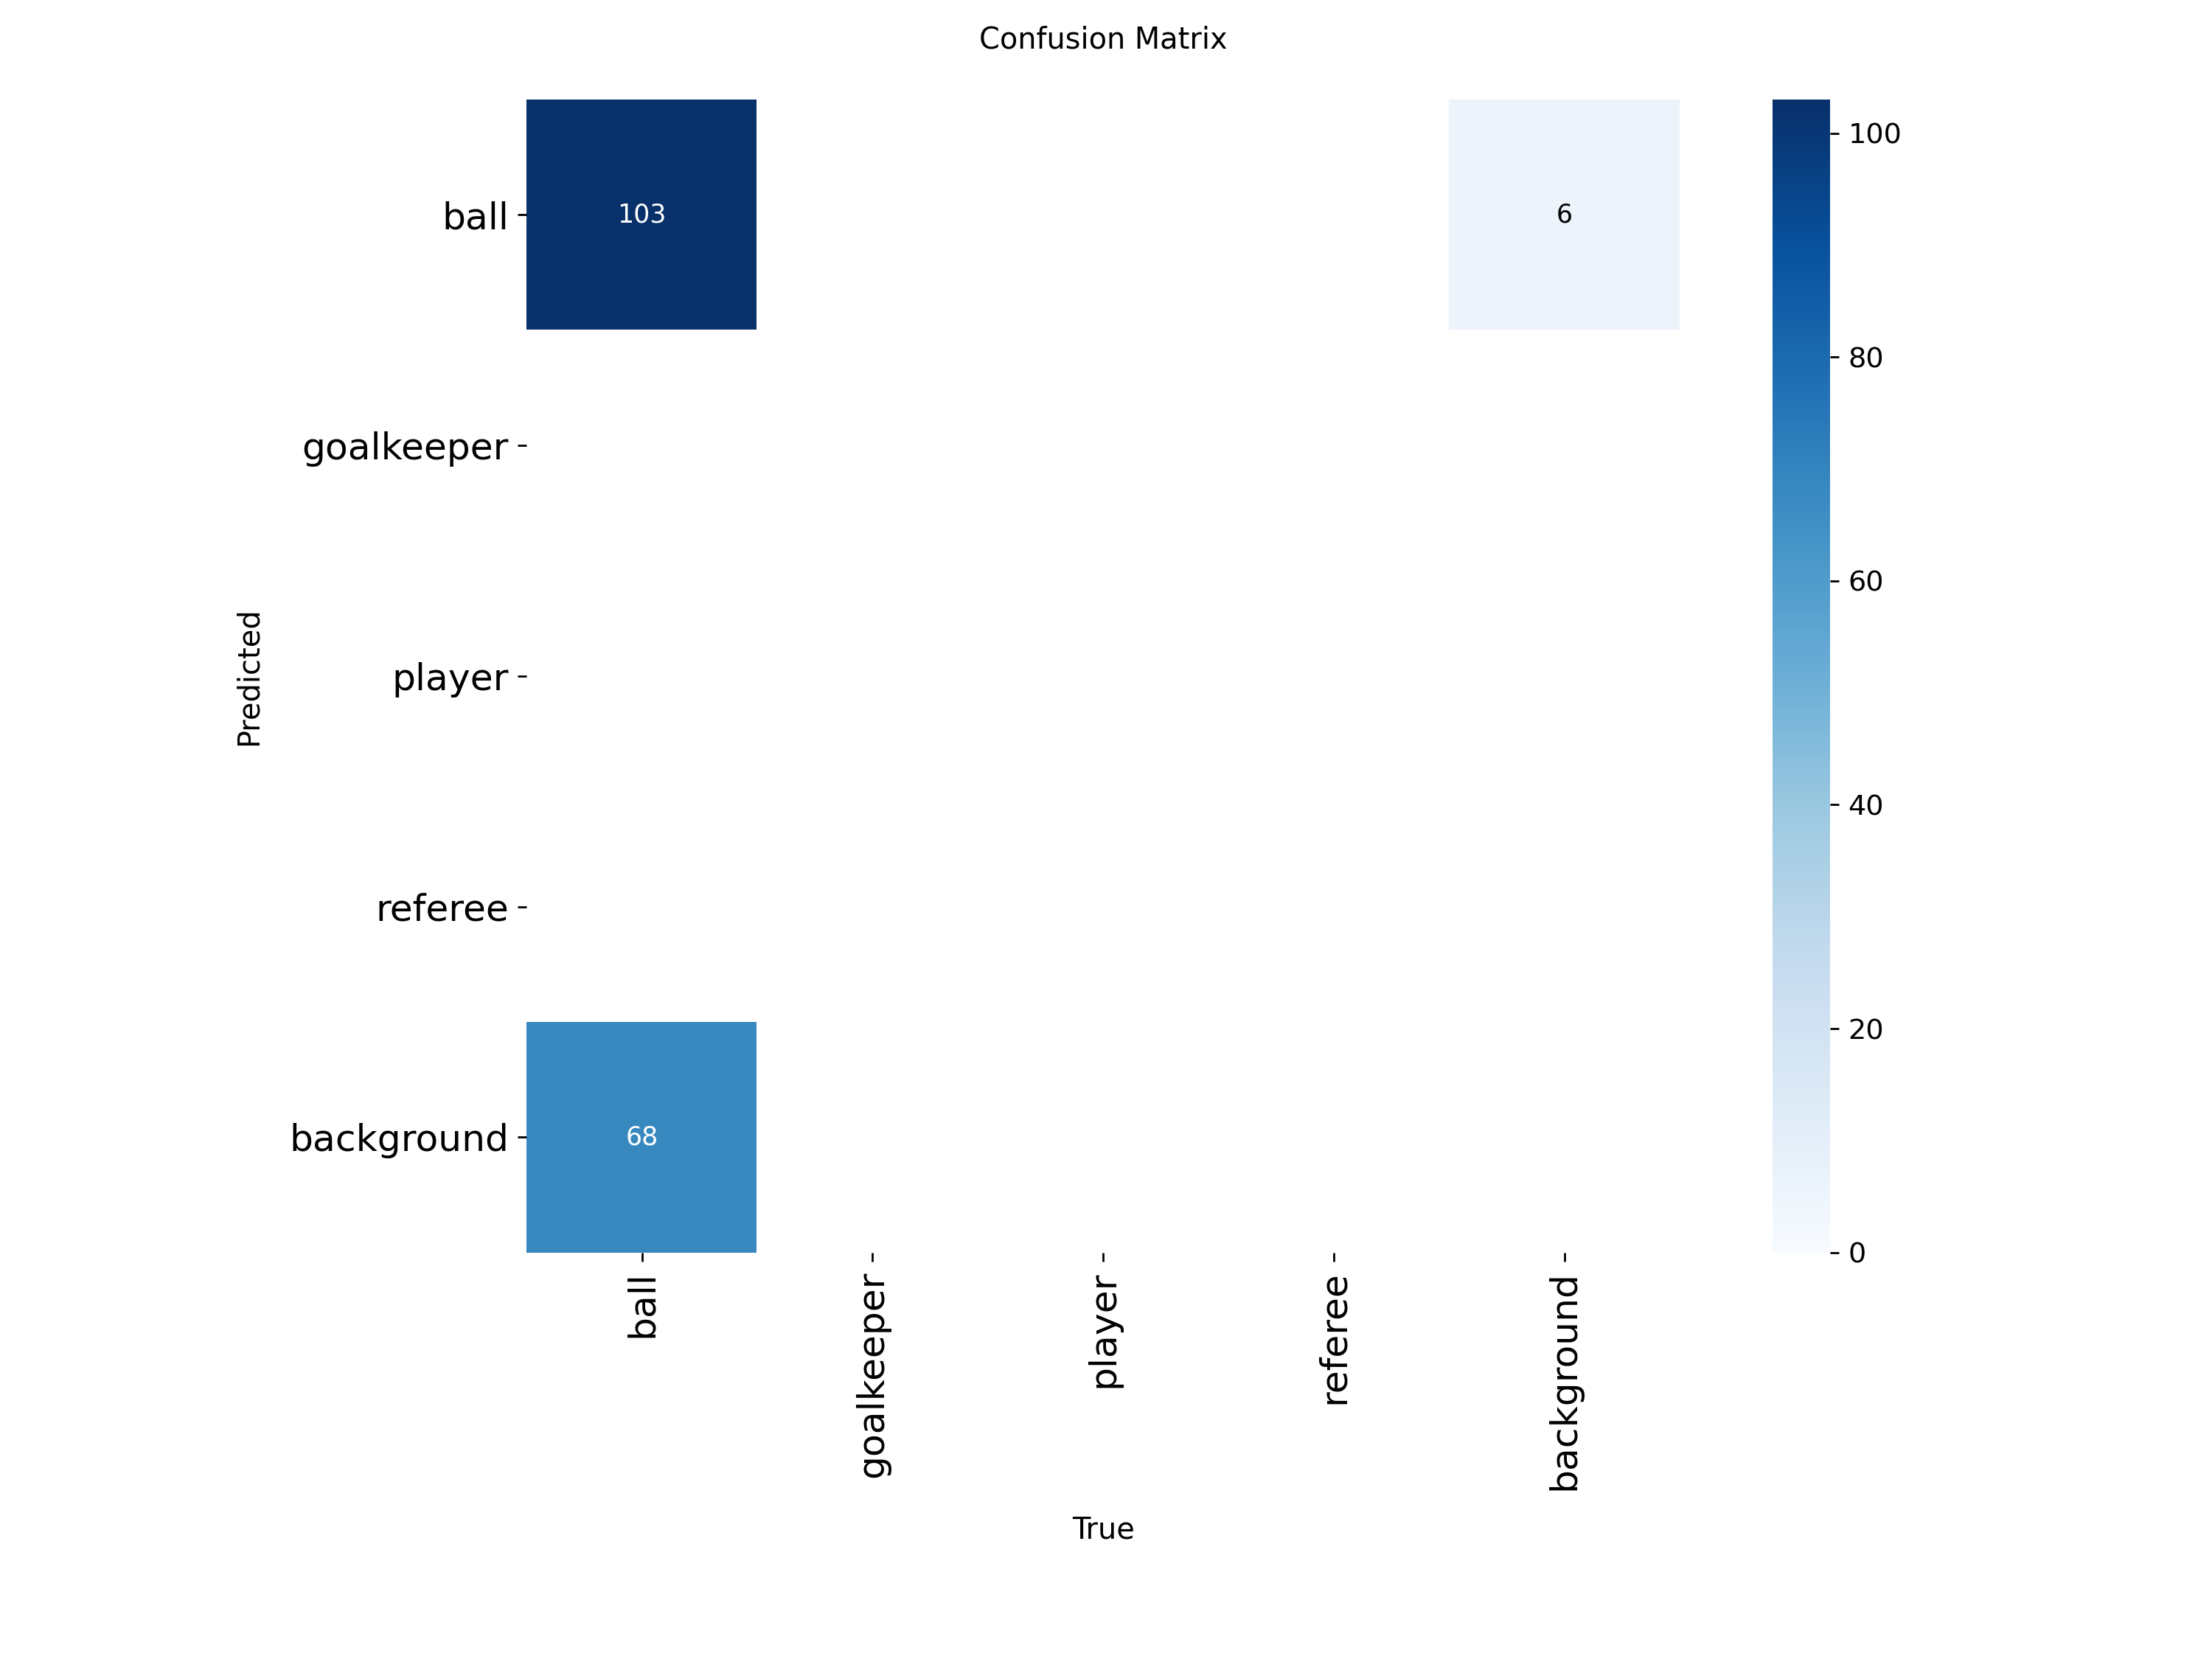

In [14]:
from IPython.display import Image, display
# Mostra matriz de confusão
display(Image(filename=f"{RUN_DIR}/confusion_matrix.png", width=600))

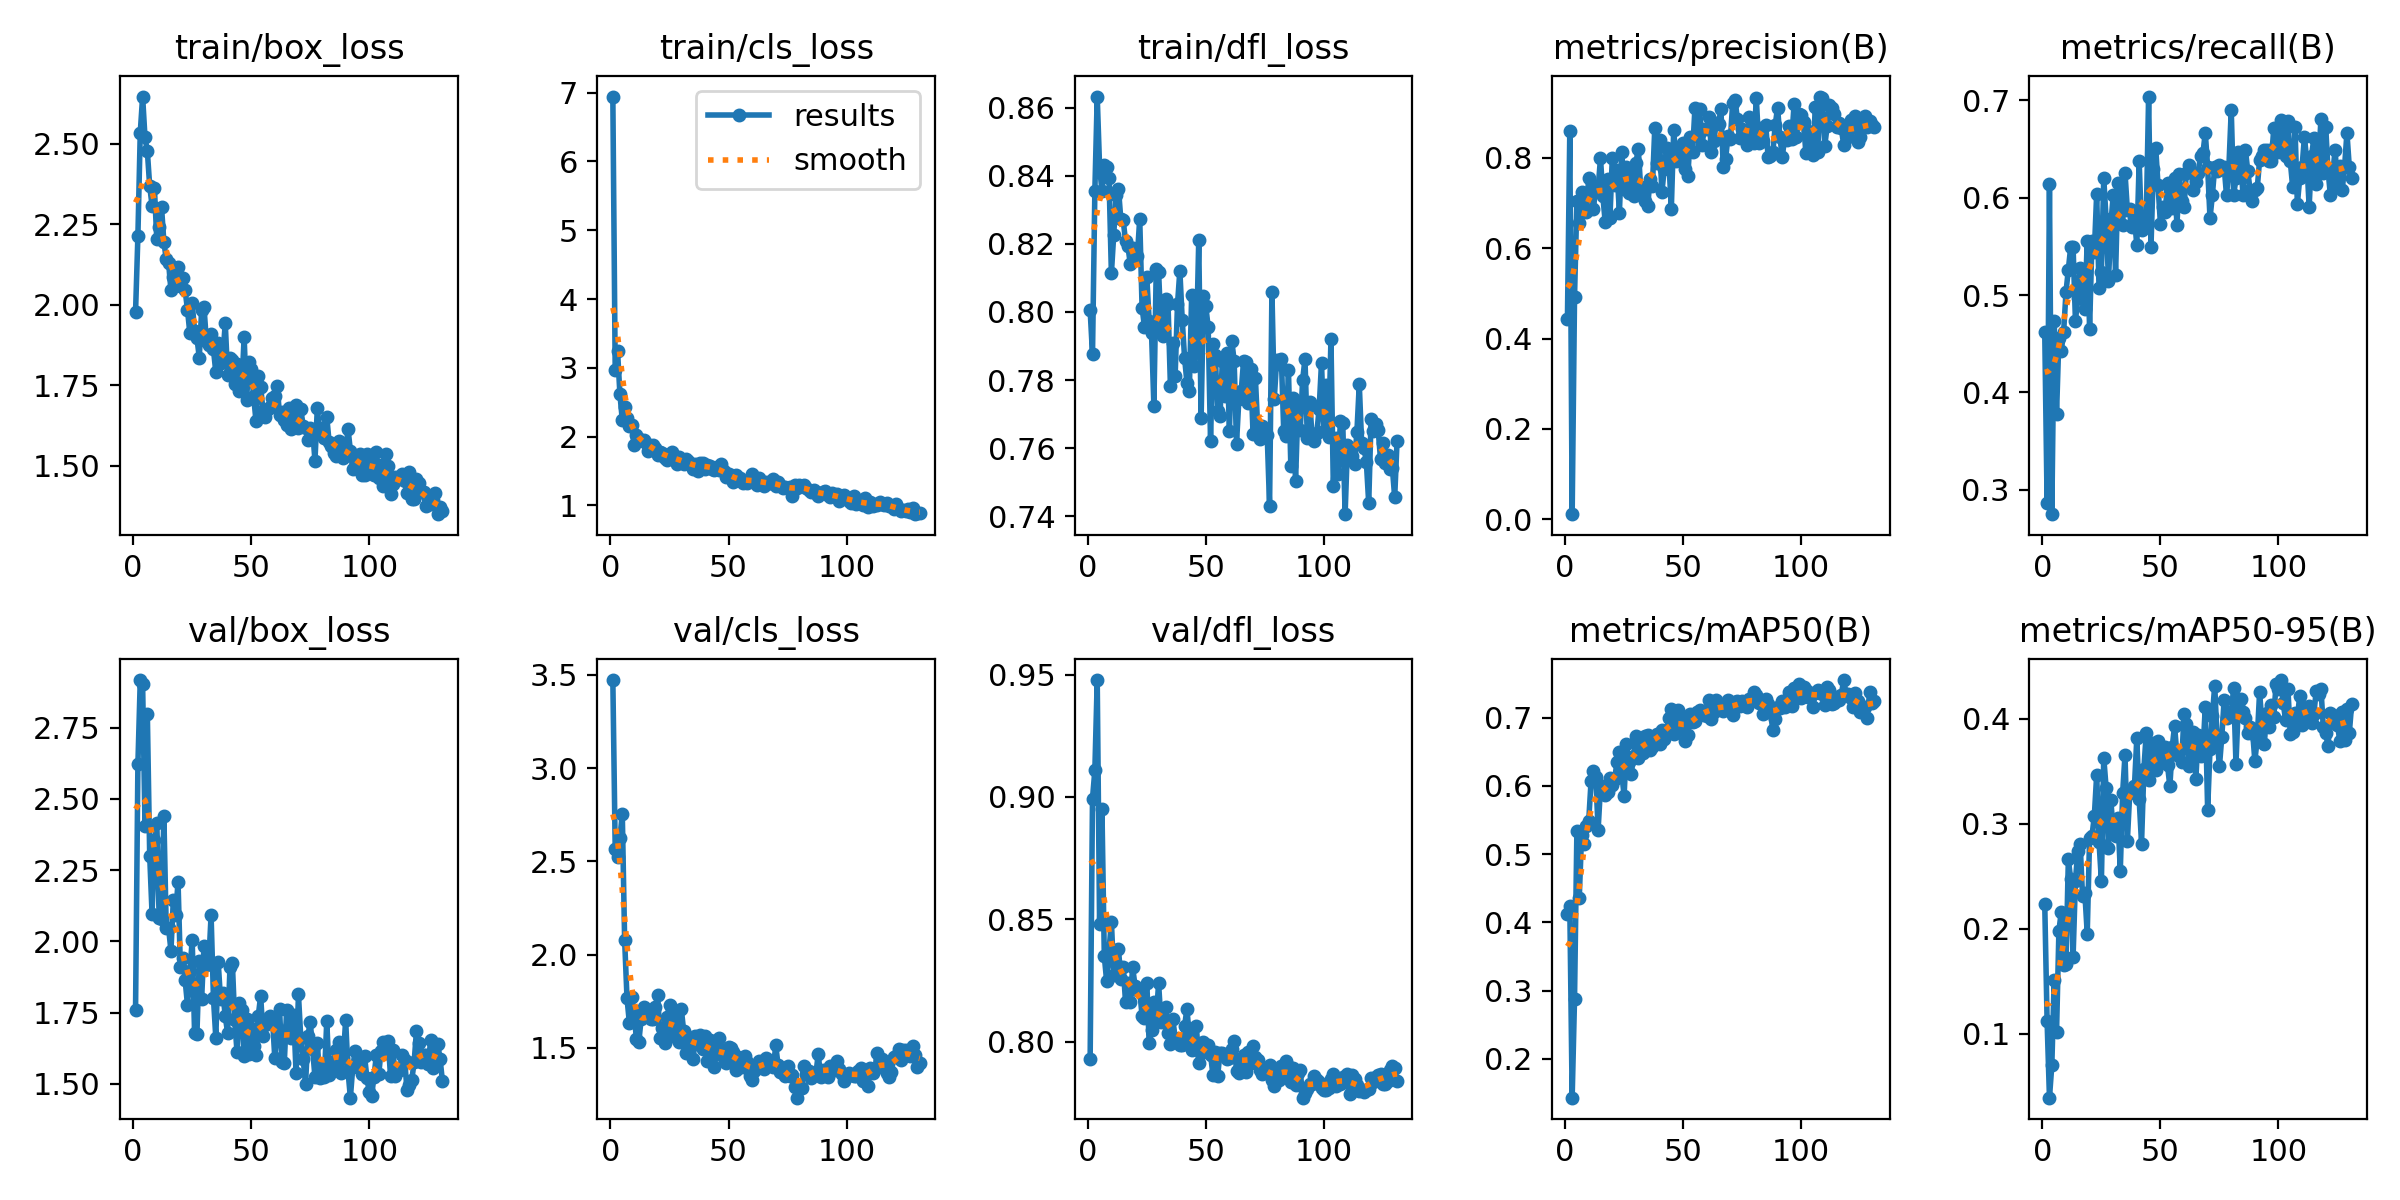

In [15]:
from IPython.display import Image, display
# Mostra gráfico de resultados (losses/mAP)
display(Image(filename=f"{RUN_DIR}/results.png", width=600))

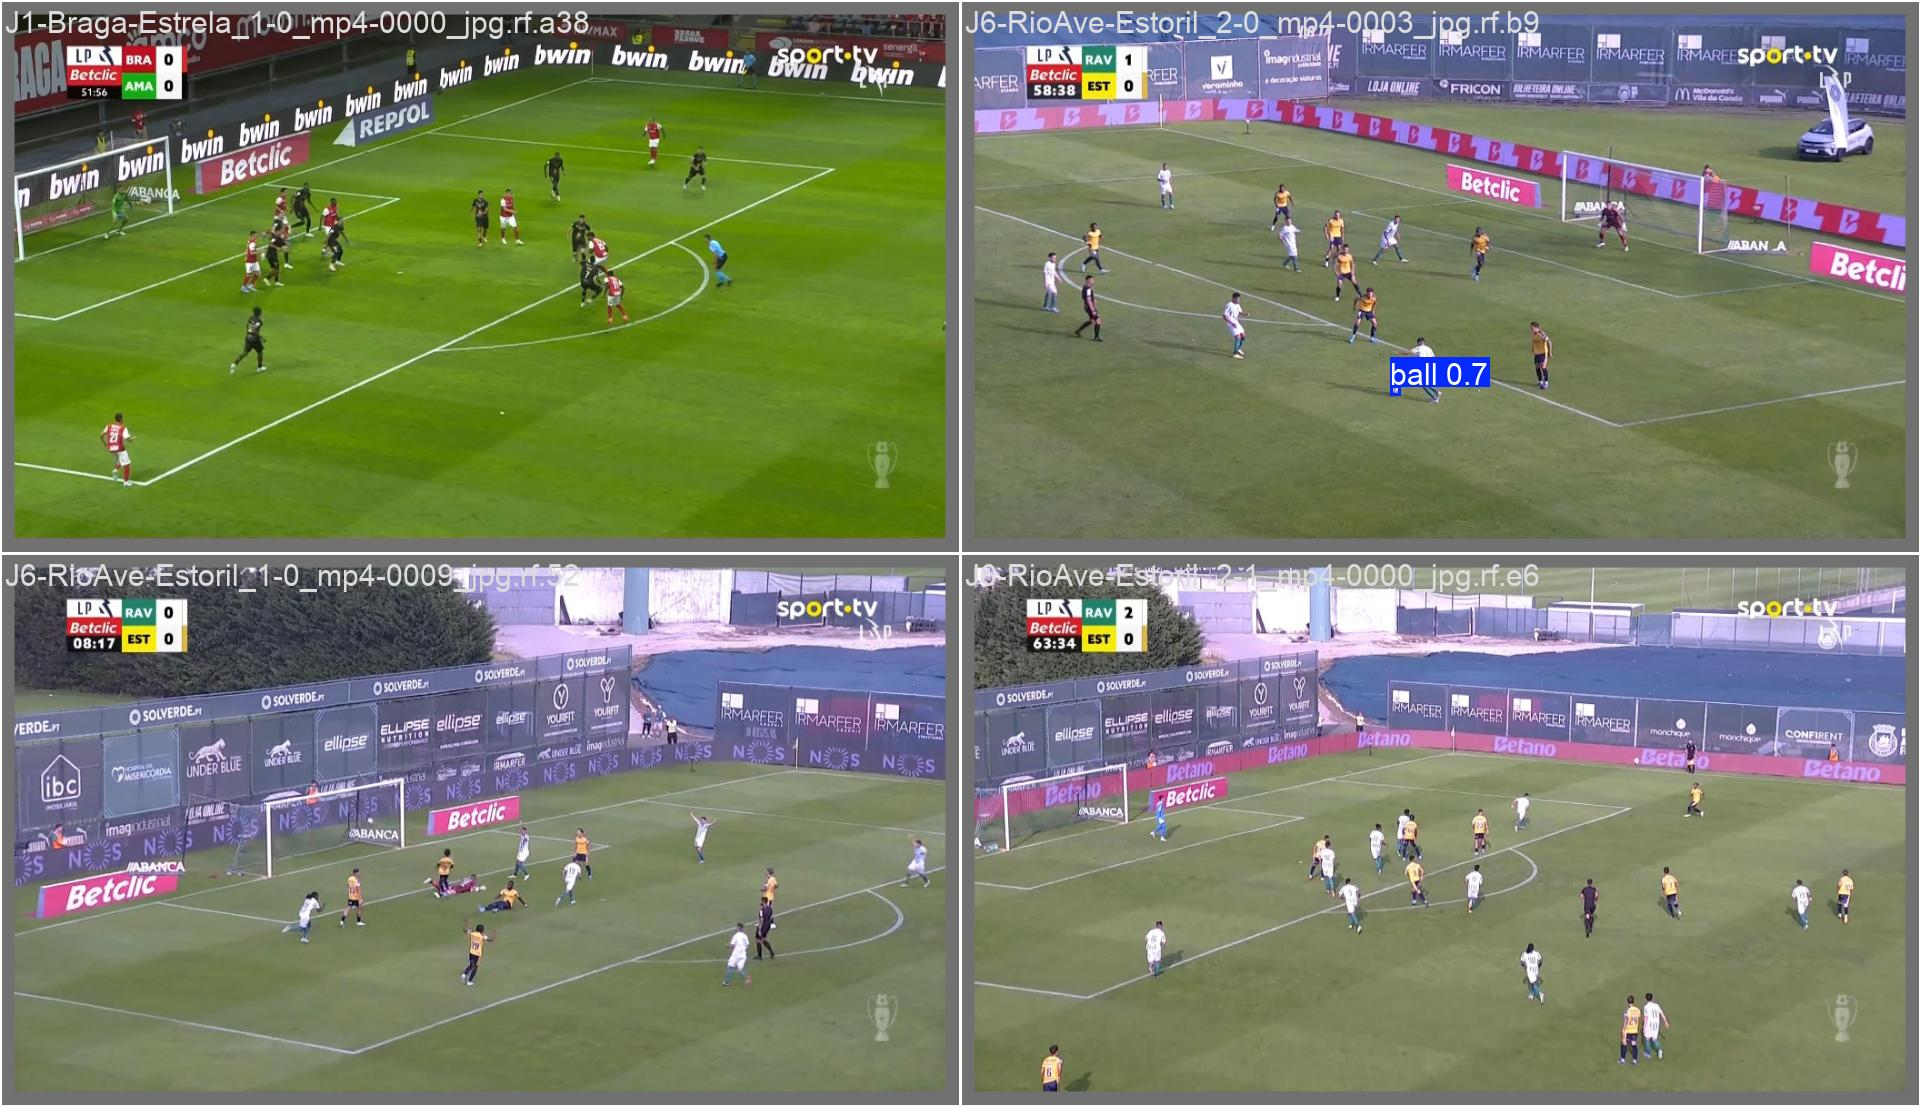

In [16]:
from IPython.display import Image, display
# Mostra predições do batch de validação
display(Image(filename=f"{RUN_DIR}/val_batch0_pred.jpg", width=600))

## Validate custom model

In [17]:
# Validação usando a API Python (evita problemas de CLI e paths com espaços)
metrics = model.val(data=data_path, imgsz=640, batch=4, device=0, workers=0)
print(f"mAP50: {metrics.box.map50:.3f}  |  mAP50-95: {metrics.box.map:.3f}")

Ultralytics 8.3.221  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2094.7526.0 MB/s, size: 197.3 KB)
val: Fast image access  (ping: 0.00.0 ms, read: 2094.7526.0 MB/s, size: 197.3 KB)
val: Scanning C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1\valid\labels.cache... 202 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 202/202  0.0s
val: Scanning C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1\valid\labels.cache... 202 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 202/202  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 11.0it/s 4.6s0.1s
                 Class     Images  Instances      Box(P         

In [18]:
# Comparação com treino anterior (se existir)
import os
import csv

old_results = os.path.join(HOME, "runs", "detect", "train_ball_y12m_footar", "results.csv")
if os.path.exists(old_results):
    print("=" * 60)
    print("COMPARAÇÃO: Treino Anterior vs Atual")
    print("=" * 60)
    
    # Lê último epoch do treino anterior
    with open(old_results, 'r') as f:
        reader = csv.DictReader(f)
        old_rows = list(reader)
        old_last = old_rows[-1]
    
    print("\n📊 TREINO ANTERIOR (50 epochs, imgsz=640):")
    print(f"  Precision: {float(old_last['metrics/precision(B)']):.3f}")
    print(f"  Recall:    {float(old_last['metrics/recall(B)']):.3f}  ← PROBLEMA!")
    print(f"  mAP50:     {float(old_last['metrics/mAP50(B)']):.3f}")
    
    print("\n📊 TREINO ATUAL (validação abaixo):")
    print(f"  Esperado: Recall > 0.60, mAP50 > 0.50")
    print("=" * 60)
else:
    print("Treino anterior não encontrado (primeira execução)")

Treino anterior não encontrado (primeira execução)


In [19]:
# Análise detalhada do treino atual
import csv

results_csv = os.path.join(RUN_DIR, "results.csv")

with open(results_csv, 'r') as f:
    reader = csv.DictReader(f)
    rows = list(reader)

print("\n" + "=" * 60)
print("ANÁLISE DETALHADA - TREINO OTIMIZADO")
print("=" * 60)

# Última época
last = rows[-1]
precision = float(last['metrics/precision(B)'])
recall = float(last['metrics/recall(B)'])
map50 = float(last['metrics/mAP50(B)'])
map5095 = float(last['metrics/mAP50-95(B)'])

print(f"\n📊 MÉTRICAS FINAIS (Epoch {len(rows)}):")
print(f"  Precision:  {precision:.3f} ({precision*100:.1f}%)")
print(f"  Recall:     {recall:.3f} ({recall*100:.1f}%) {'✅ MELHOROU!' if recall > 0.5 else '⚠️ Ainda baixo'}")
print(f"  mAP50:      {map50:.3f} ({map50*100:.1f}%) {'✅ BOM!' if map50 > 0.5 else '⚠️ Razoável'}")
print(f"  mAP50-95:   {map5095:.3f} ({map5095*100:.1f}%)")

# Evolução
print(f"\n📈 EVOLUÇÃO:")
checkpoints = [0, 24, 49, len(rows)-1]
for idx in checkpoints:
    if idx < len(rows):
        epoch = idx + 1
        map_val = float(rows[idx]['metrics/mAP50(B)'])
        recall_val = float(rows[idx]['metrics/recall(B)'])
        print(f"  Epoch {epoch:3d}: mAP50={map_val:.3f}, Recall={recall_val:.3f}")

# Melhor época
best_map50 = max(float(r['metrics/mAP50(B)']) for r in rows)
best_epoch = [i+1 for i, r in enumerate(rows) if float(r['metrics/mAP50(B)']) == best_map50][0]

print(f"\n🏆 MELHOR ÉPOCA: {best_epoch} (mAP50={best_map50:.3f})")
if best_epoch < len(rows):
    print(f"   ⚠️ Melhor resultado não foi no final!")
    print(f"   → Usar weights do epoch {best_epoch}: epoch{best_epoch}.pt")

print("\n" + "=" * 60)


ANÁLISE DETALHADA - TREINO OTIMIZADO

📊 MÉTRICAS FINAIS (Epoch 131):
  Precision:  0.869 (86.9%)
  Recall:     0.621 (62.1%) ✅ MELHOROU!
  mAP50:      0.724 (72.4%) ✅ BOM!
  mAP50-95:   0.414 (41.4%)

📈 EVOLUÇÃO:
  Epoch   1: mAP50=0.412, Recall=0.462
  Epoch  25: mAP50=0.585, Recall=0.524
  Epoch  50: mAP50=0.683, Recall=0.573
  Epoch 131: mAP50=0.724, Recall=0.621

🏆 MELHOR ÉPOCA: 118 (mAP50=0.755)
   ⚠️ Melhor resultado não foi no final!
   → Usar weights do epoch 118: epoch118.pt



## Copy optimized model to production

Copia o modelo treinado para o diretório `data/` onde o `main.py` espera encontrá-lo.

In [20]:
import shutil
import os

# Determina qual epoch usar (melhor ou último)
results_csv = os.path.join(RUN_DIR, "results.csv")
with open(results_csv, 'r') as f:
    reader = csv.DictReader(f)
    rows = list(reader)

best_map50 = max(float(r['metrics/mAP50(B)']) for r in rows)
best_epoch = [i+1 for i, r in enumerate(rows) if float(r['metrics/mAP50(B)']) == best_map50][0]

# Caminhos
weights_dir = os.path.join(RUN_DIR, "weights")
best_weights = os.path.join(weights_dir, "best.pt")
data_dir = os.path.join(HOME, "..", "data")
os.makedirs(data_dir, exist_ok=True)

destination = os.path.join(data_dir, "ball_y12m_footar_best.pt")

# Copia
shutil.copy2(best_weights, destination)

print("=" * 60)
print("✅ MODELO COPIADO PARA PRODUÇÃO")
print("=" * 60)
print(f"Origem:  {best_weights}")
print(f"Destino: {destination}")
print(f"\n📝 PRÓXIMO PASSO:")
print(f"   Atualizar main.py linha ~48:")
print(f"   BALL_DETECTION_MODEL_PATH = 'data/ball_y12m_footar_best.pt'")
print(f"\n🎯 Melhor época foi: {best_epoch}")
if best_epoch < len(rows):
    print(f"   ⚠️ Se quiser usar epoch {best_epoch} especificamente:")
    epoch_file = f"epoch{best_epoch}.pt"
    if os.path.exists(os.path.join(weights_dir, epoch_file)):
        print(f"   Copiar: {os.path.join(weights_dir, epoch_file)}")
print("=" * 60)

✅ MODELO COPIADO PARA PRODUÇÃO
Origem:  C:/_FOOTAR/Player Detection/roboflow_sports_footar/notebooks/runs/detect/train_ball_y11m_1024_focus\weights\best.pt
Destino: c:\_FOOTAR\Player Detection\roboflow_sports_footar\notebooks\..\data\ball_y12m_footar_best.pt

📝 PRÓXIMO PASSO:
   Atualizar main.py linha ~48:
   BALL_DETECTION_MODEL_PATH = 'data/ball_y12m_footar_best.pt'

🎯 Melhor época foi: 118
   ⚠️ Se quiser usar epoch 118 especificamente:


## Optional: Deploy model on Roboflow (YOLOv8 only)

Note: Roboflow's deploy(model_type="yolov8") currently requires ultralytics==8.0.196. This notebook trains with YOLOv12 on ultralytics 8.3.x, so deploying from here will fail. You can:
- Upload the weights file manually in the Roboflow UI (Versions -> Upload Model -> YOLOv8) using RUN_DIR/weights/best.pt
- Or create a separate env with ultralytics==8.0.196 and run the deploy cell there.


In [21]:
# Guarded deploy: skip if ultralytics version is not the one required by Roboflow's deploy
import os
import ultralytics as ulx

# Resolve RUN_DIR and WEIGHTS path safely
try:
    RUN_DIR
except NameError:
    import glob
    base = os.path.join(HOME, "runs", "detect")
    # fallback: pick most recent detect run
    candidates = glob.glob(os.path.join(base, "*"))
    candidates = [p for p in candidates if os.path.isdir(p)]
    RUN_DIR = max(candidates, key=os.path.getmtime) if candidates else None

if RUN_DIR is None:
    print("No run directory found; train the model first.")
else:
    weights_path = os.path.join(RUN_DIR, "weights", "best.pt")
    need = "8.0.196"
    have = ulx.__version__
    if have == need:
        print(f"Deploying {weights_path} to Roboflow as YOLOv8 with ultralytics {have}...")
        project.version(dataset.version).deploy(model_type="yolov8", model_path=weights_path)
    else:
        print(f"Skipping deploy: Roboflow requires ultralytics=={need}, but found {have}.")
        print("Options:")
        print("  1) Upload manually in Roboflow UI: Versions -> Upload Model -> YOLOv8")
        print(f"     Weights: {weights_path}")
        print("  2) Create a separate env with ultralytics==8.0.196 and run this cell there.")

Skipping deploy: Roboflow requires ultralytics==8.0.196, but found 8.3.221.
Options:
  1) Upload manually in Roboflow UI: Versions -> Upload Model -> YOLOv8
     Weights: C:/_FOOTAR/Player Detection/roboflow_sports_footar/notebooks/runs/detect/train_ball_y11m_1024_focus\weights\best.pt
  2) Create a separate env with ultralytics==8.0.196 and run this cell there.
